In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import tensorflow as tf
import tf_agents
import gym
import gym_maze

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
import pygame
pygame.init()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


(4, 1)

## Maze Environment

The maze environment implementation we will use is an open source custom OpenAI Gym environment called [Gym-Maze](https://github.com/MattChanTK/gym-maze).

> [Gym-Maze is a] simple 2D maze environment where an agent (blue dot) finds its way from the top left corner (blue square) to the goal at the bottom right corner (red square). The objective is to find the shortest path from the start to the goal. The agent may only choose to go up, down, right, or left ("N", "S", "E", "W"). If the way is blocked, it will remain at the same the location. The observation space is the (x, y) coordinate of the agent. The top left cell is (0, 0). A reward of 1 is given when the agent reaches the goal. For every step in the maze, the agent recieves a reward of -0.1/(number of cells).

In [2]:
from mlrl.maze_env import make_maze_env, render_maze as render

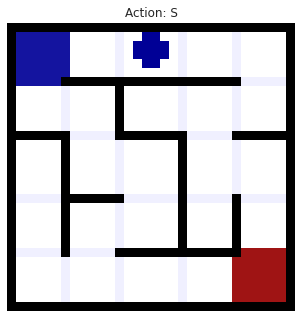

In [7]:
from IPython.display import clear_output
import time

env = make_maze_env()

try:
    env.reset()
    title = f'Action: None'
    while True:
        # render
        render(env, title=title)
        clear_output(wait=True)
        time.sleep(0.05)
        
        # act
        random_action = env.action_space.sample()
        title = f'Action: {env.ACTION[random_action]}'
        env.step(random_action)
        
except KeyboardInterrupt:
    pass

## Tracking and Setting States

In order to construct a search tree over the environment we need to be able to track and set the object-level states. Each node in a search tree will hold a state that we have explored, but we do not want to constantly copy the entire environment object as most of this will be irrelevant information. In order to perform a node expansion we will set the environment state to the state of the node, perform an action using `env.step`, and create a new child node from the resultant state of the environment.

The Gym-Maze environment tracks the state of the robot in the maze with the `env.state` and `env.maze_view._MazeView2D__robot` variables. But we also need to track the `env.steps_beyond_done` and `env.done` variables in order to prevent issues when we use `env.step`. When setting a state we follow the same procedure as `env.reset`, except with our target variables. This procedure can be seen [here in the Gym-Maze source code](https://github.com/MattChanTK/gym-maze/blob/83176811b49b5538a6213520612f44fb1bc49114/gym_maze/envs/maze_env.py#L92).

### Creating getters/setters

Reseting the environment and taking a random direction

In [3]:
env = make_maze_env(maze_size=(10, 10), seed=42)

In [4]:
move_right_action = 2
env.step(move_right_action)

(array([1, 0]), -0.001, False, {})

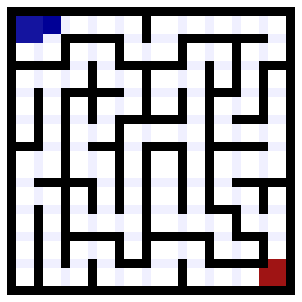

In [5]:
render(env)

Keep note of this state, as it is what we will aim to restore

Defining the state getters and setters

In [7]:
from mlrl.maze_env import get_maze_state as get_state
from mlrl.maze_env import set_maze_state as set_state

Storing the current state to show the getter work

In [8]:
state = get_state(env)
state

(array([1, 0]), None, False)

Taking another few steps to the right.

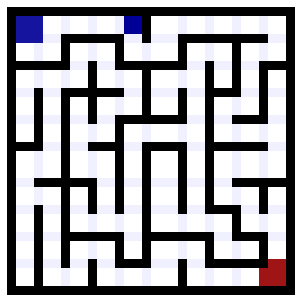

In [9]:
for _ in range(3):
    env.step(move_right_action)
render(env)

Seeing that the `set_state` function correctly restores the original state before the second step.

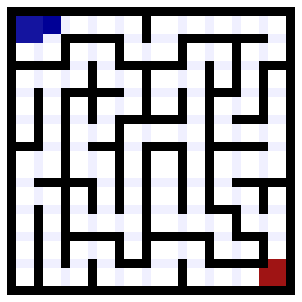

In [10]:
set_state(env, state)
render(env)

Move down from the restored state to confirm that the state was properly reconfigured.

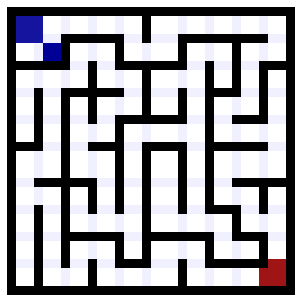

In [11]:
move_down_action = 1
env.step(move_down_action)
render(env)

## Search Tree Representation

In [12]:
from mlrl.maze_state import MazeState
from mlrl.search_tree import SearchTree, SearchTreeNode

In [13]:
env = make_maze_env()

search_tree = SearchTree(env, MazeState.extract_state)
search_tree

action=None, reward=0, state=(0, 0), children=defaultdict(<class 'list'>, {})

In [14]:
import random
random.seed(0)

N = 50
for i in range(N):
    node = random.choice(list(range(len(search_tree.get_nodes()))))
    action = random.randint(0, env.action_space.n - 1)
    if N <= 10:
        print(f'Expanding {search_tree.get_nodes()[node].state} with action {env.ACTION[action]}')
    search_tree.expand(node, action)

In [15]:
from networkx.drawing.nx_pydot import graphviz_layout
from mlrl.utils.hierarchical_pos import hierarchy_pos_large_tree
import networkx as nx


def construct_tree(tree: nx.DiGraph, node: SearchTreeNode):
    tree.add_node(hash(node), state=str(node.state))
    for action, children in node.get_children().items():
        for child in children:
            construct_tree(tree, child)
            tree.add_edge(hash(node), hash(child), 
                action=env.ACTION[action], 
                reward=child.get_reward_received())


def show_tree(search_tree: SearchTree, figsize=(20, 20), show_reward=False):

    nx_tree = nx.DiGraph()
    construct_tree(nx_tree, search_tree.get_root())

    pos = hierarchy_pos_large_tree(nx_tree, hash(search_tree.get_root()), width=250, height=250)
    edge_labels = {
        (n1, n2): '{} ({:.2f})'.format(data['action'], data['reward']) if show_reward else data['action']
        for n1, n2, data in nx_tree.edges(data=True)
    }
    node_labels = {
        node: nx_tree.nodes.get(node)['state'] for node in nx_tree.nodes()
    }

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()

    nx.draw(nx_tree, pos, node_size=1800, ax=ax)

    nx.draw_networkx_edge_labels(nx_tree, pos, edge_labels=edge_labels, ax=ax)
    nx.draw_networkx_labels(nx_tree, pos, labels=node_labels, ax=ax, font_color='white')
    plt.axis('off')
    axis = plt.gca()
    zoom = 10
    axis.set_xlim([axis.get_xlim()[0] - zoom, axis.get_xlim()[1] + zoom])
    axis.set_ylim([axis.get_ylim()[0] - zoom, axis.get_ylim()[1] + zoom])
    # plt.tight_layout()
    plt.show()

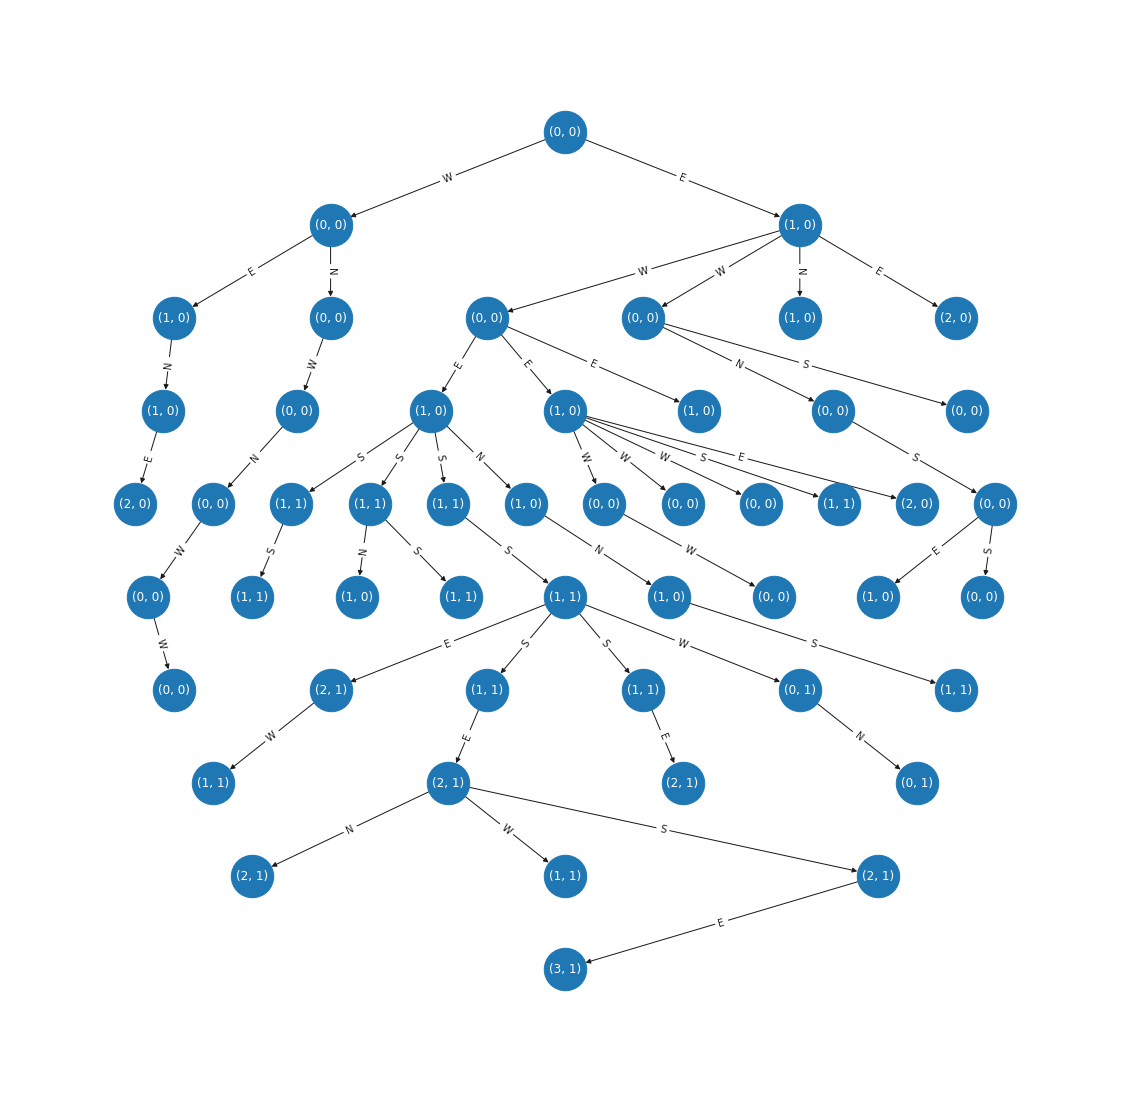

In [16]:
show_tree(search_tree)

## Search-Amplified Object-level Q-Value Estimation

In [17]:
from mlrl.q_estimation import SimpleSearchBasedQEstimator, QFunction
from mlrl.manhattan_q import ManhattanQHat

In [18]:
def create_maze_state(pos: np.array, env: 'MazeEnv') -> MazeState:
    gym_state = (pos, 0, np.array_equal(pos, env.maze_view.goal), env._elapsed_steps)
    return MazeState(pos, gym_state) 

In [19]:
def visualise_q_hat(q_hat: QFunction, env: 'MazeEnv'):
    """
        Function to visualise the Q function for a maze environment.
    """
    maze_w, maze_h = env.maze_size
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for action, ax in enumerate(axs):
        q_vals = np.array([[
                q_hat(create_maze_state(np.array([x, y]), env), action)
                for x in range(maze_w)
            ] for y in range(maze_h)
        ])
        q_vals[env.maze_view.goal[1], env.maze_view.goal[0]] = 0
        
        ax.set_title(f'Action: {env.ACTION[action]}')
        sns.heatmap(q_vals, annot=True, square=maze_w==maze_h, fmt='.2f', cbar=False, ax=ax, vmin=0, vmax=1);
        ax.axis('off')
    
    plt.show()
    render(env)

In [20]:
def visualise_manhattan_q_hat(env: 'MazeEnv'):
    q_hat = ManhattanQHat(env)
    visualise_q_hat(q_hat, env)

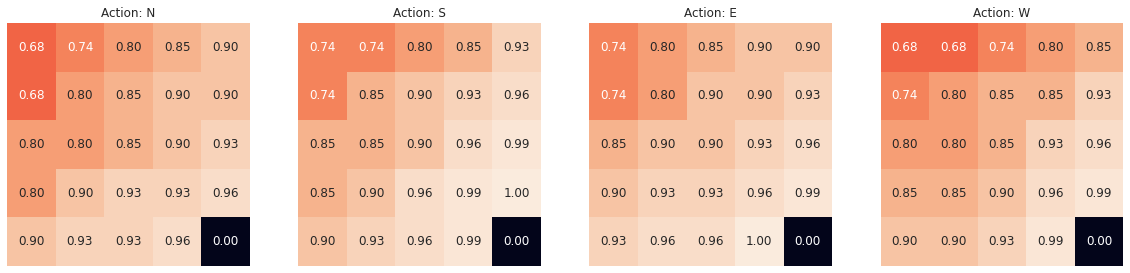

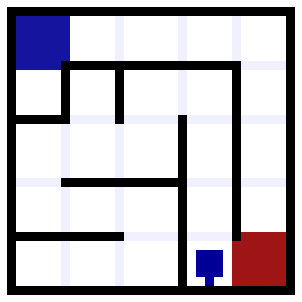

In [24]:
env = make_maze_env((5, 5), seed=42)
visualise_manhattan_q_hat(env)

In [25]:
def create_depth_n_tree(env: 'MazeEnv', start_pos: np.array, n: int = 2) -> SearchTree:
    root_state = create_maze_state(start_pos, env)
    root_state.set_environment_to_state(env)
    search_tree = SearchTree(env, extract_state=MazeState.extract_state)
    to_expand = [0]
    for _ in range(n):
        new_to_expand = []
        for node_idx in to_expand:
            for action in range(env.action_space.n):
                success = search_tree.expand(node_idx, action)
                if success:
                    new_node_idx = len(search_tree.node_list) - 1
                    new_to_expand.append(new_node_idx)
        to_expand = new_to_expand

    return search_tree

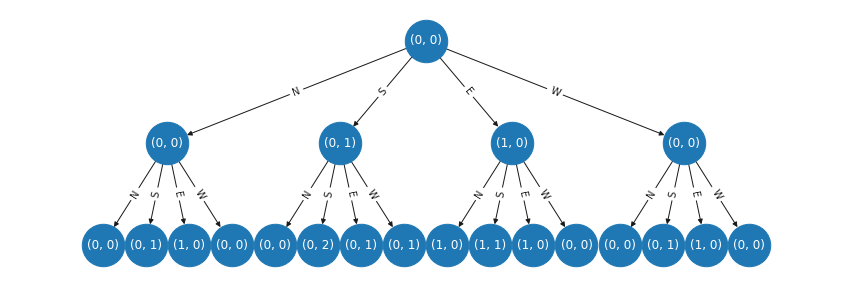

In [26]:
env = make_maze_env()
tree = create_depth_n_tree(env, np.array([0, 0]), 2)
show_tree(tree, figsize=(15, 5))

In [27]:
class DepthNSearchQFn(QFunction):
    
    def __init__(self, env: 'MazeEnv', n: int = 2):
        self.env = env
        self.q_hat = ManhattanQHat(env)
        self.n = n
        
    def compute_q(self, state: MazeState, action: int) -> float:
        state_pos = state.get_state_vector()
        search_tree = create_depth_n_tree(self.env, state_pos, self.n)
        q_est = SimpleSearchBasedQEstimator(self.q_hat, search_tree)
        return q_est.compute_q(search_tree.get_root(), action)

In [28]:
def visualise_depth_n_q_hat(env: 'MazeEnv', n: int = 2):
    q_hat = DepthNSearchQFn(env, n=n)
    visualise_q_hat(q_hat, env)

In [34]:
env = make_maze_env(seed=42)

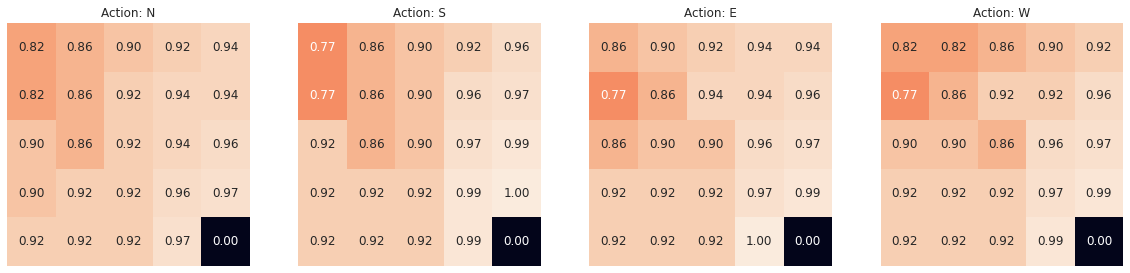

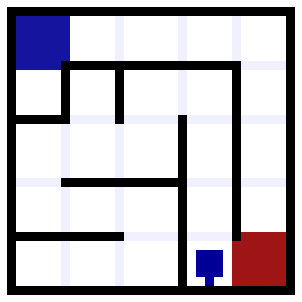

In [35]:
visualise_depth_n_q_hat(env, 3)

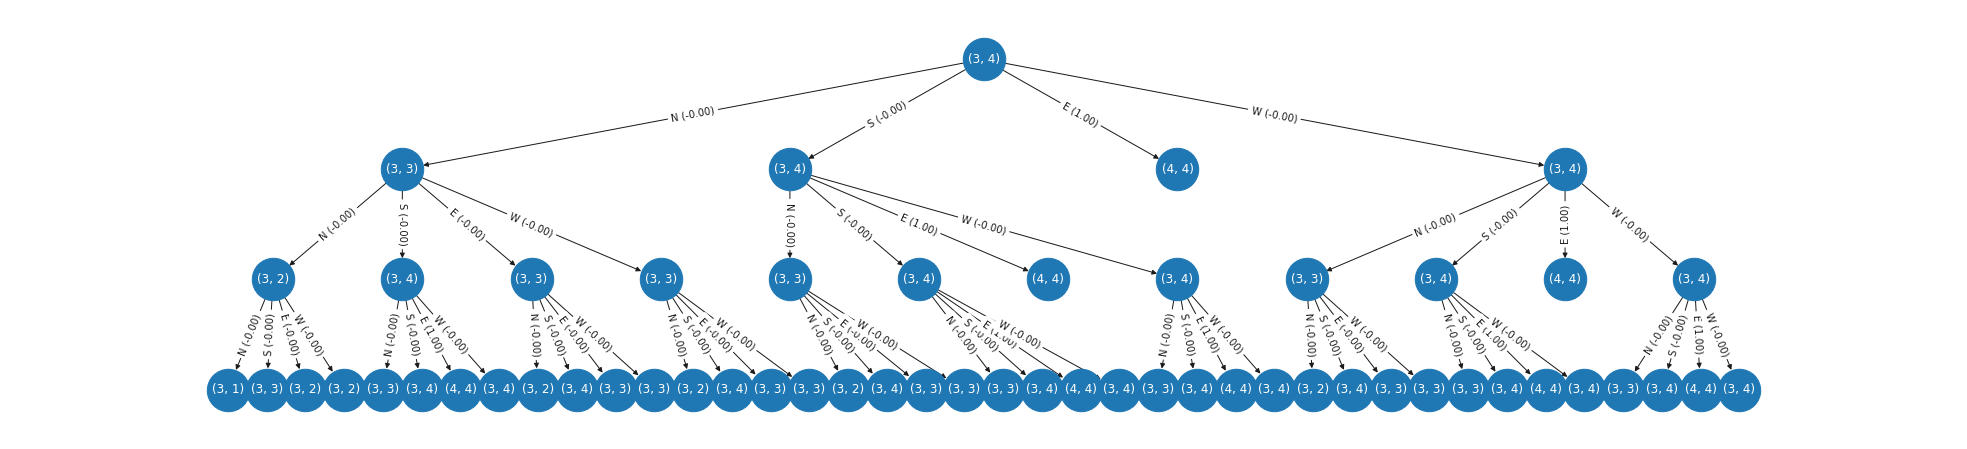

In [36]:
pos = env.maze_view.goal - np.array([1, 0])
show_tree(create_depth_n_tree(env, pos, 3), 
          figsize=(35, 8), show_reward=True)

## Creating the Meta Environment

In [39]:
from mlrl.maze_env import make_maze_env
from mlrl.search_tree import SearchTree
from mlrl.meta_env import MetaEnv
from mlrl.manhattan_q import ManhattanQHat

env = make_maze_env(seed=42)
q_hat = ManhattanQHat(env)

def make_maze_search_tree(env: 'MazeEnv') -> SearchTree:
    return SearchTree(env, extract_state=MazeState.extract_state)

meta_env = MetaEnv(env, q_hat, make_maze_search_tree)

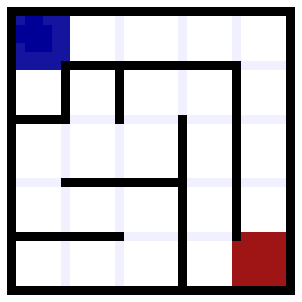

In [40]:
meta_env.reset()
render(env)

In [41]:
def create_q_table(meta_env: MetaEnv) -> pd.DataFrame:
    q_est = SimpleSearchBasedQEstimator(meta_env.q_hat, meta_env.tree)
    return pd.DataFrame([
        [int(v[-2]), int(v[-1])] + [q_est.compute_q(node, a) for a in range(meta_env.env.action_space.n)]
        for node in meta_env.tree.node_list
        if (v := meta_env.tokenise_node(node))[0] == 1.0
    ], columns = ['X', 'Y'] + [f'Q((X, Y), {a})' for a in meta_env.env.ACTION])

In [42]:
q_table1 = create_q_table(meta_env)
q_table1

,X,Y,"Q((X, Y), N)","Q((X, Y), S)","Q((X, Y), E)","Q((X, Y), W)"
0,0,0,0.675528,0.741848,0.741848,0.675528


In [43]:
meta_env.get_observation()

array([[ 1., -1., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [44]:
expand_node = 0
object_action = env.ACTION.index('S')
meta_action = 1 + 4 * expand_node + object_action
meta_env.step(meta_action)

(array([[ 1.   , -1.   , -1.   ,  0.   ,  0.   ,  0.   ],
        [ 1.   ,  0.   ,  1.   , -0.004,  0.   ,  1.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]),
 0,
 False,
 {})

In [45]:
q_table2 = create_q_table(meta_env)
q_table2

,X,Y,"Q((X, Y), N)","Q((X, Y), S)","Q((X, Y), E)","Q((X, Y), W)"
0,0,0,0.675528,0.730430,0.741848,0.675528
1,0,1,0.675528,0.741848,0.741848,0.741848


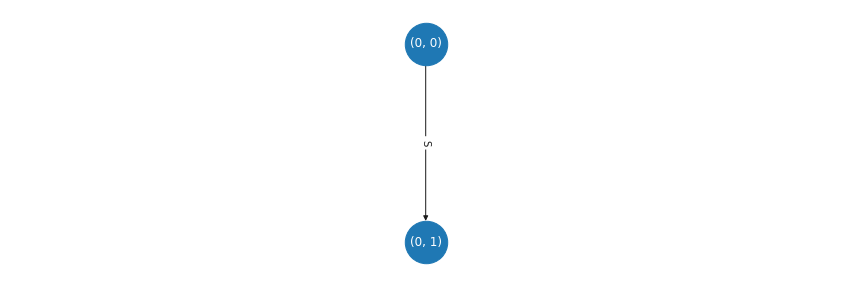

In [46]:
show_tree(meta_env.tree, figsize=(15, 5))

In [47]:
expand_node = 0
object_action = env.ACTION.index('E')
meta_action = 1 + 4 * expand_node + object_action
meta_env.step(meta_action)

(array([[ 1.   , -1.   , -1.   ,  0.   ,  0.   ,  0.   ],
        [ 1.   ,  0.   ,  1.   , -0.004,  0.   ,  1.   ],
        [ 1.   ,  0.   ,  2.   , -0.004,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]),
 0,
 False,
 {})

In [48]:
q_table3 = create_q_table(meta_env)
q_table3

,X,Y,"Q((X, Y), N)","Q((X, Y), S)","Q((X, Y), E)","Q((X, Y), W)"
0,0,0,0.675528,0.730430,0.789022,0.675528
1,0,1,0.675528,0.741848,0.741848,0.741848
2,1,0,0.741848,0.741848,0.801033,0.675528


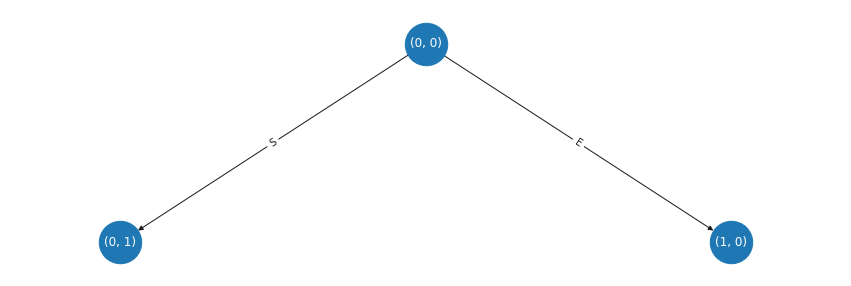

In [49]:
show_tree(meta_env.tree, figsize=(15, 5))

In [50]:
expand_node = 2
object_action = env.ACTION.index('E')
meta_action = 1 + 4 * expand_node + object_action
meta_env.step(meta_action)

(array([[ 1.   , -1.   , -1.   ,  0.   ,  0.   ,  0.   ],
        [ 1.   ,  0.   ,  1.   , -0.004,  0.   ,  1.   ],
        [ 1.   ,  0.   ,  2.   , -0.004,  1.   ,  0.   ],
        [ 1.   ,  2.   ,  2.   , -0.004,  2.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]),
 0,
 False,
 {})

In [51]:
q_table4 = create_q_table(meta_env)
q_table4

,X,Y,"Q((X, Y), N)","Q((X, Y), S)","Q((X, Y), E)","Q((X, Y), W)"
0,0,0,0.675528,0.730430,0.828036,0.675528
1,0,1,0.675528,0.741848,0.741848,0.741848
2,1,0,0.741848,0.741848,0.840440,0.675528
3,2,0,0.801033,0.801033,0.852970,0.741848


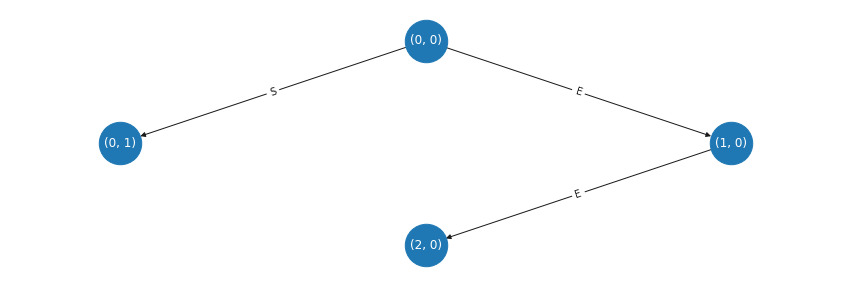

In [52]:
show_tree(meta_env.tree, figsize=(15, 5))

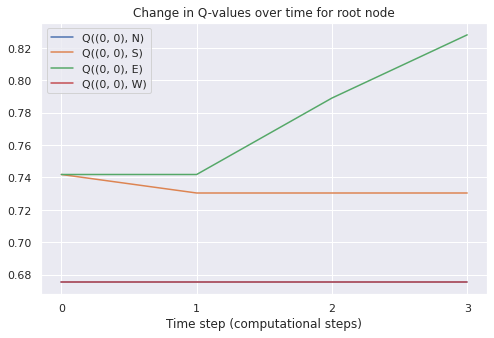

In [53]:
q_tables = [q_table1, q_table2, q_table3, q_table4]
q_df = pd.DataFrame([q_table.iloc[0, 2:] for q_table in q_tables])
q_df = q_df.reset_index().drop(columns='index')
q_df.columns = [col.replace('X', '0').replace('Y', '0') for col in q_df.columns]

plt.figure(figsize=(8, 5))
sns.lineplot(data=q_df, dashes=False)
plt.xlabel('Time step (computational steps)')
plt.xticks(q_df.index)
plt.title('Change in Q-values over time for root node')
plt.show()

In [54]:
q_df

,"Q((0, 0), N)","Q((0, 0), S)","Q((0, 0), E)","Q((0, 0), W)"
0,0.675528,0.741848,0.741848,0.675528
1,0.675528,0.730430,0.741848,0.675528
2,0.675528,0.730430,0.789022,0.675528
3,0.675528,0.730430,0.828036,0.675528


In [55]:
meta_action = 0  # take object action (terminate computation)
meta_env.step(meta_action)

(array([[ 1., -1., -1.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]),
 -0.004,
 False,
 {})

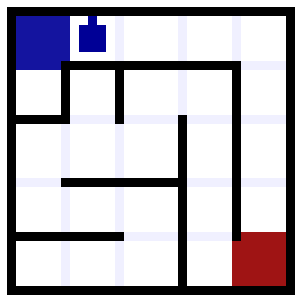

In [56]:
render(env)